<a href="https://colab.research.google.com/github/scottwmwork/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction.
- [ ] If you log-transformed your regression target, then convert your PDP back to original units. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [33]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install pdpbox
    !pip install category_encoders==2.0.0
    !pip install pandas-profiling==2.3.0
    !pip install plotly==4.1.1

In [0]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/scottwmwork/datasets/master/tmdb_5000_movies.csv')

In [35]:
df.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [0]:
#Make Genres a compatible feature

X = df #Copy df into X (Doing this so I can easily copy the following code into my wrangle function)

import ast
import numpy as np

genre = []
for x in X['genres']:
  if x == '[]':
    genre.append(np.nan)
  else:
    temp = ast.literal_eval(x) 
    genre.append(temp[0]['name']) #grabs first genre in list of dictionaries
    
#create new column for dataframe
X['genre_first_listed'] = genre

In [37]:
X['genre_first_listed'].value_counts().unique

<bound method Series.unique of Drama              1207
Comedy             1042
Action              754
Adventure           339
Horror              300
Crime               195
Thriller            194
Animation           123
Fantasy             117
Romance             106
Science Fiction      96
Documentary          89
Family               56
Mystery              41
Music                34
Western              27
History              25
War                  24
TV Movie              4
Foreign               2
Name: genre_first_listed, dtype: int64>

In [0]:
df['release_date'] = pd.to_datetime(df['release_date'],infer_datetime_format = True)
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_day'] = df['release_date'].dt.month
df = df.drop(columns = 'release_date')

In [0]:
#Isolate the test set
test = df[df['release_year'] == 2016]
y_test = test['revenue']
X_test = test.drop(columns = 'revenue')


#Exclude test set from data
dfn = df[df['release_year'] != 2016]

In [0]:
#Create train and validation data 
from sklearn.model_selection import train_test_split
train, val = train_test_split(dfn, train_size = .80, test_size = 0.20, random_state = 42)

y_train = train.revenue
X_train = train.drop(columns = 'revenue')

y_val = val.revenue
X_val = val.drop(columns = 'revenue')

In [0]:
import ast
import numpy as np

def wrangle(X):
  
  X = X.copy()
  X = X.reset_index()

  #Make genres column usable
  genre = []
  for x in X['genres']:
    if x == '[]':
      genre.append(np.nan)
    else:
      temp = ast.literal_eval(x) 
      genre.append(temp[0]['name']) #grabs first genre in list of dictionaries
    

  #Features to not include:
  X = X.drop(columns = ['genres','homepage','keywords','overview','production_companies','production_countries','spoken_languages','tagline'])
  
  #Engineer features:
  
  #original title is same as title?    
  title_changed = []
  for x in range(0,len(X['title'])):
    if X['title'][x] == X['original_title'][x]:
       title_changed.append(0)
    else:
       title_changed.append(1)
  
  #length of title
  length_of_title = []
  for x in X['title']:
    length_of_title.append(len(x))
  
  #Add features to dataframe
  X['title_changed'] = title_changed
  X['length_of_title'] = length_of_title
  X['genre_first_listed'] = genre
   
  
  return X

In [0]:
#Wrangle data
X_test = wrangle(X_test)
X_val = wrangle(X_val)
X_train = wrangle(X_train)

In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
  # SimpleImputer(strategy = 'mean'),
  ce.OneHotEncoder(use_cat_names = True),
  SimpleImputer(),  
#   DecisionTreeClassifier(random_state = 5),
#   LinearRegression()
#   LogisticRegression()
    RandomForestRegressor()
)

pipeline.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['original_language', 'original_title',
                                     'status', 'title', 'genre_first_listed'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan,...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                             

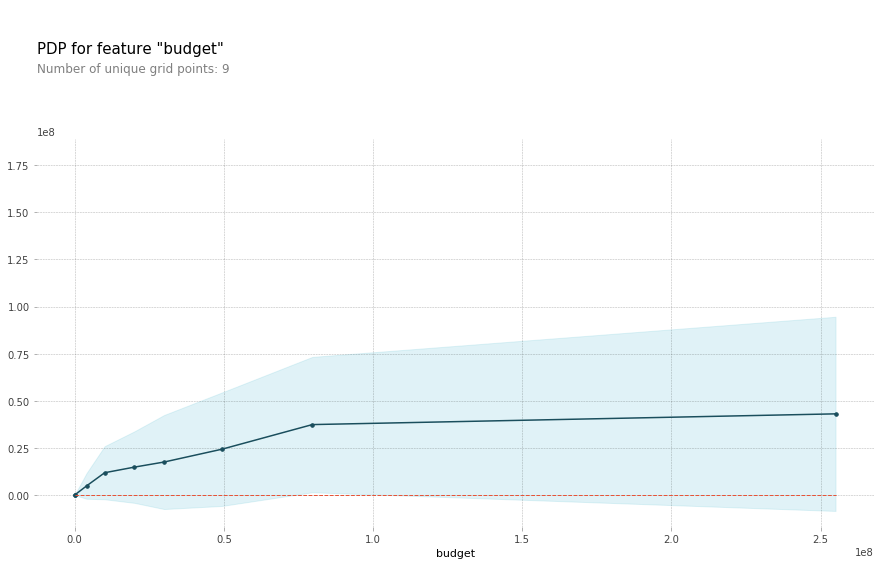

In [46]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'budget'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

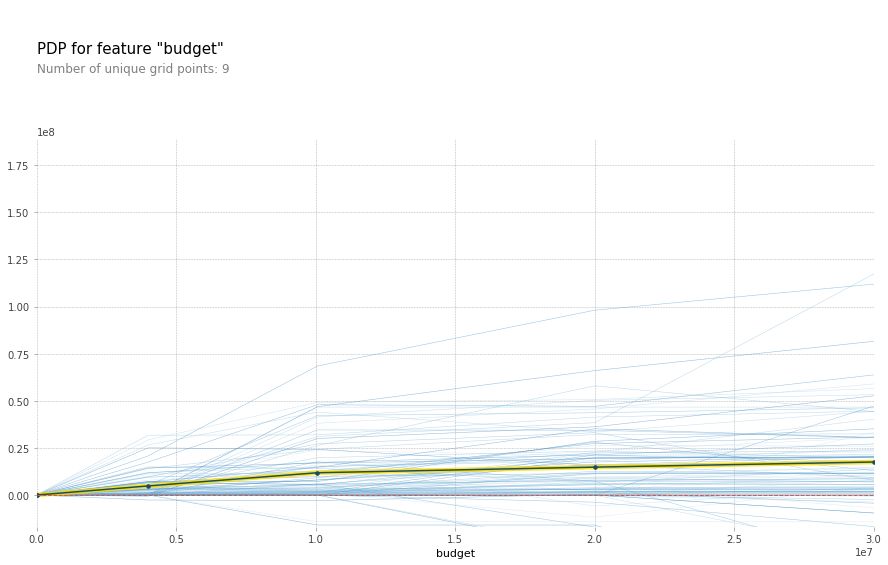

In [56]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100) # Plot 100 ICE lines
plt.xlim(0,30000000);